In [42]:
"""
This cell only contains functionality for computing and visualizing the matrix.
The next cell will contain the parameters.
"""

import numpy as np
from rumor_centrality import graph_simulations
from rumor_centrality import graph_generator
from matplotlib import pyplot as plt
import rumor_centrality.jordan_center_alternative as jo

from rumor_centrality import rumor_detection
import networkx as nx

def predict_center(infected_graph):
    """
    Uses Rumor Centrality to predict the center of the given graph
    """
    return rumor_detection.get_center_prediction(rumor_detection.networkx_graph_to_adj_list(infected_graph), use_fact=False)

def get_hop_distance(g, center: int, predicted_center: int, diameter):
    """
    Finds the diameter normalized hop distance between the center and the prediction
    """

    # Notify if either nodes are missing
    if not g.has_node(center) or not g.has_node(predicted_center):
        print("Actual or predicted center not in graph")

    # If Graph is not connected we cannot find hop distance
    if not is_connected(g):
        return -1

    dist = nx.shortest_path_length(g, center, predicted_center)

    # Diameter normlization
    if diameter is not None:
        return dist / diameter
    else:
        return dist

def is_connected(g: nx.Graph) -> bool:
    # Works for both directed and undirected graphs
    return nx.is_directed(g) and nx.is_strongly_connected(g) or not nx.is_directed(g) and nx.is_connected(g)

def predict(model_conf, predictor_conf, graphs, use_avg):
    """
    Runs the prediction on an infected graph and returns the hop distance
    """
    predictor, can_handle_unconnected = predictor_conf
    graph_i, model = model_conf
    graph = graphs[graph_i]
    g, diameter = graph
    infection, center = model

    # If there are no nodes we cannot predict
    if len(infection.nodes) == 0:
        return -1

    # If predictor can not handle unconnected graphs and graph is unconnected -> invalid
    if not can_handle_unconnected and not is_connected(infection):
        return -1

    predicted = predictor(infection)
    if len(predicted) == 0:
        print("Predicted zero centers")
        return -1

    if use_avg:
        # Jordan Centrality returns multiple centers and we compute average hop distance
        return np.array([get_hop_distance(g, center[0], p, diameter) for p in predicted]).mean()
    else:
        return get_hop_distance(g, center[0], predicted[0], diameter)

def run_sim(times, count, sim, graphs):
    """
    Runs the simulation multiple times on the given graphs
    """
    models = []
    for _ in range(times):
        for g, graph in enumerate(graphs):
            models.append((g, sim(graph[0], count)))
    return models

def frequencies(predictions):
    """
    Computes a histogram of the given dataset
    """
    values = [-1 if v is None else v for v in predictions]
    uniq_values = list(set(values))
    return dict([(u, values.count(u)) for u in uniq_values])

def valid_and_invalid(data):
    """
    Takes histogram data of valid and invalid hops.
    Returns a set of valid data and sum of invalid hops
    """
    valid_data = [(hops, occurrences) for hops, occurrences in data.items() if hops != - 1]
    invalid_data = [occurrences for hops, occurrences in data.items() if hops == - 1]
    invalid_occurrences = sum(invalid_data)
    return valid_data, invalid_occurrences

def mean_of_frequency(data):
    """
    Computes the mean of the histogram
    """
    values = []
    for hops, occurrences in data:
        values.extend([hops for _ in range(occurrences)])
    if len(values) == 0:
        return None
    return np.array(values).mean()

def mod_ax(ax, max, tick_freq):
    ax.set_xlim([1, max[0]])
    ax.set_ylim([0, max[1]])
    ax.xaxis.set_ticks(np.arange(0, max[0] + 1, tick_freq[0]))
    ax.yaxis.set_ticks(np.arange(0, max[1], tick_freq[1]))


def avg_matrix(n, m, p, infection_counts, data, row_names, col_names, p_names, max, tick_freq, def_colors=None):
    """
    Draw the Matrix visualization

    :param n: Number of rows (Dynamics)
    :param m: Number of columns (Graph Types)
    :param p: Number of Predictors
    :param data: Histogram Data for each row, column and predictor
    :param row_names: Names of Dynamics
    :param col_names: Names of Graph Types
    :param p_names: Names of Predictors
    :param max: maximum value for x- and y-axis
    :param tick_freq: Where ticks should be placed on the x- and y-axis
    """
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(12, 8), sharex='all', sharey='all')
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    if n != 1 and m != 1:
        for ax in axes.flat:
            mod_ax(ax, max, tick_freq)
    else:
        mod_ax(axes, max, tick_freq)

    print("Compute invalids and frequency")
    avgs = []
    invalids = []
    for row in range(n):
        avgs.append([])
        invalids.append([])
        for col in range(m):
            avgs[-1].append([])
            invalids[-1].append([])
            for bar in range(p):
                avgs[-1][-1].append([])
                invalids[-1][-1].append([])
                for i in range(len(infection_counts)):
                    valid_freq, invalid_count = valid_and_invalid(data[i][row][col][bar])
                    mean = mean_of_frequency(valid_freq)
                    avgs[-1][-1][-1].append(mean)
                    invalids[-1][-1][-1].append(invalid_count)

    # Set Colors
    if def_colors is not None:
        colors = def_colors
    else:
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    print("Draw")
    for row in range(n):
        for col in range(m):
            if n == 1 and m == 1:
                ax = axes
            else:
                ax = axes[row, col]
            for bar in range(p):
                ax.plot(np.array(infection_counts), avgs[row][col][bar], color=colors[bar], label=p_names[bar])
                ax.plot(np.array(infection_counts), np.array(invalids[row][col][bar]) / 500 * 10, color=colors[bar], linestyle=":", label=p_names[bar])

            if row == n - 1:
                ax.set(xlabel=col_names[col])
            if col == 0:
                ax.set(ylabel=row_names[row])
    # axes[0, 0].legend()
    return fig


import pickle
import os.path

def save(data, name):
    if not os.path.exists(f"{name}.pickle"):
        with open(f"{name}.pickle", "wb") as f:
            print("Look Morty, I turned myself into a pickle")
            pickle.dump(data, f)

def load(name):
    if os.path.exists(f"{name}.pickle"):
        with open(f"{name}.pickle", "rb") as f:
            return pickle.load(f)


In [3]:
# List of all used Dynamics, infection_count is variable
sim_si = lambda g, i: graph_simulations.si(g, -1, 0.3, 1, i, 10, True)
sim_sis = lambda g, i: graph_simulations.sis(g, -1, 0.3, 0.1, 1, i, 10, True)
sim_sir = lambda g, i: graph_simulations.sir(g, -1, 0.3, 0.1, 1, i, 10, True)
simulations = [sim_si, sim_sis, sim_sir]
sim_names = ["SI", "SIS", "SIR"]

# Predictions
rc_prediction = lambda infected_g: predict_center(infected_g)
jo_prediction = lambda infected_g: jo.centers_by_jordan_center(infected_g)
bc_prediction = lambda infected_g: jo.centers_by_betweenness_centrality(infected_g)
dc_prediction = lambda infected_g: jo.centers_by_distance_centrality(infected_g)
# The bool determains whether the predicted centers should all be averaged in the hop distance computation
predictors = [(rc_prediction, True), (jo_prediction, False), (bc_prediction, False), (dc_prediction, False)]
predictor_names = ["Rumour Centrality", "Jordan Center", "Betweenness Centrality", "Distance Centrality"]

# Infection counts
infection_counts = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Graph Types
small_world_g = lambda: graph_generator.small_world(1000, 100, 0.1)
scale_free_g = lambda: nx.Graph(graph_generator.scale_free(1000))
synthetic_internet_g = lambda: graph_generator.synthetic_internet(1000)
internet_g = lambda: graph_generator.internet()
us_power_grid_g = lambda: graph_generator.us_power_grid()

graphs_types = [small_world_g, scale_free_g, synthetic_internet_g, us_power_grid_g]
graph_names = ["Small World", "Scale Free", "Synthetic Internet", "US Power Grid"]

# How many times each graph type is generated
graph_counts = 5
# How many times each simulation is run per graph
simulation_times = 10


In [18]:
# Generates the graphs. This takes a lot of time, so you might want to split it into multiple runs and save it to disk
def generate_graphs(g, graph_type):
    print(f"Generating graph {graph_names[g]}")
    graphs = []
    while len(graphs) < graph_counts:
        new_graph = graph_type()
        if not is_connected(new_graph):
            print("Graph is not connected, skipping")
        else:
            graphs.append(new_graph)
    print("Calculating Diameters")
    return [(graph, nx.diameter(graph)) for graph in graphs]

graphs = [generate_graphs(g, graph_type) for g, graph_type in enumerate(graphs_types)]

save(graphs, "graphs")

Generating graph Small World
Calculating Diameters
Generating graph Scale Free
Graph is not connected, skipping
Calculating Diameters
Generating graph Synthetic Internet
Calculating Diameters
Generating graph US Power Grid
Calculating Diameters
Look Morty, I turned myself into a pickle


In [2]:
# graphs = load("graphs")
# print(len(graphs))

4


In [19]:
# Print all graphs (used to check for errors)
print(f"Len: {len(graphs)}")
print(f"Connected Small World: {[is_connected(g[0]) for g in graphs[0]]}")
print(f"Connected Scale Free: {[is_connected(g[0]) for g in graphs[1]]}")
print(f"Connected Synth Internet: {[is_connected(g[0]) for g in graphs[2]]}")
print(f"Connected US Power Grid: {[is_connected(g[0]) for g in graphs[3]]}")
print(f"Diameter Small World: {[g[1] for g in graphs[0]]}")
print(f"Diameter Scale Free: {[g[1] for g in graphs[1]]}")
print(f"Diameter Synth Internet: {[g[1] for g in graphs[2]]}")
print(f"Diameter US Power Grid: {[g[1] for g in graphs[3]]}")
print(f"Size Small World: {[len(g[0].nodes()) for g in graphs[0]]}")
print(f"Size Scale Free: {[len(g[0].nodes()) for g in graphs[1]]}")
print(f"Size Synth Internet: {[len(g[0].nodes()) for g in graphs[2]]}")
print(f"Size US Power Grid: {[len(g[0].nodes()) for g in graphs[3]]}")


Len: 4
Connected Small World: [True, True, True, True, True]
Connected Scale Free: [True, True, True, True, True]
Connected Synth Internet: [True, True, True, True, True]
Connected US Power Grid: [True, True, True, True, True]
Diameter Small World: [3, 3, 3, 3, 3]
Diameter Scale Free: [8, 8, 7, 8, 8]
Diameter Synth Internet: [7, 7, 7, 6, 6]
Diameter US Power Grid: [46, 46, 46, 46, 46]
Size Small World: [1000, 1000, 1000, 1000, 1000]
Size Scale Free: [1000, 1000, 1000, 1000, 1000]
Size Synth Internet: [1000, 1000, 1000, 1000, 1000]
Size US Power Grid: [4941, 4941, 4941, 4941, 4941]


In [7]:
# Loops over infections counts, simulations, graphs and predictors and runs the prediction for all.
sim_data = []
for _, i_count in enumerate(infection_counts):
    i_data = []
    for row, sim in enumerate(simulations):
        row_data = []
        for col, graphs_of_type in enumerate(graphs):
            col_data = []
            for p, predictor in enumerate(predictors):
                print(f"Running graph {graph_names[col]} with simulation {sim_names[row]} with {i_count} infected nodes and prediction {predictor_names[p]}")
                models = run_sim(simulation_times, i_count, sim, graphs_of_type)
                col_data.append(frequencies([predict(model, predictor, graphs_of_type, True) for model in models]))
            row_data.append(col_data)
        i_data.append(row_data)
    sim_data.append(i_data)
save(sim_data, "sim_data")

Running graph Small World with simulation SI with 1000 infected nodes and prediction Rumour Centrality
Running graph Small World with simulation SI with 1000 infected nodes and prediction Jordan Center
Running graph Small World with simulation SI with 1000 infected nodes and prediction Betweenness Centrality


KeyboardInterrupt: 

In [4]:
# sim_data = load("sim_data")

Compute invalids and frequency
Draw
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


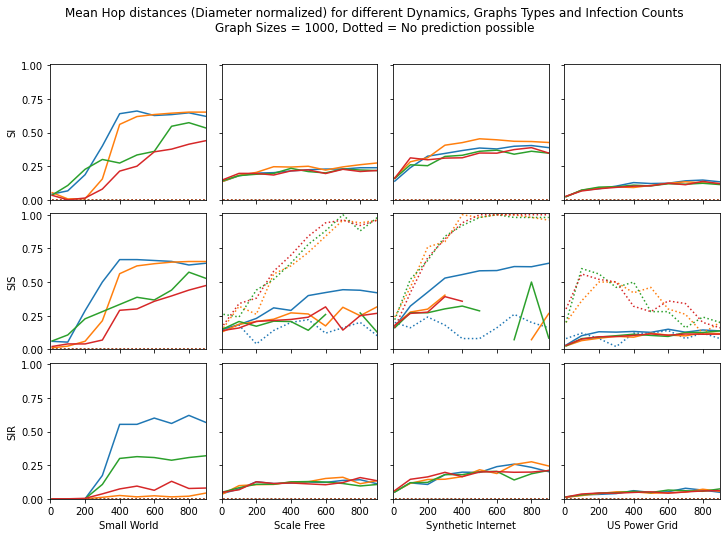

In [23]:
# Draws the matrix
fig = avg_matrix(len(simulations), len(graph_names), len(predictors), infection_counts, sim_data, sim_names, graph_names, predictor_names, (900, 1.01), (200, 0.25))
fig.suptitle(f"Mean Hop distances (Diameter normalized) for different Dynamics, Graphs Types and Infection Counts\nGraph Sizes = 1000, Dotted = No prediction possible")
plt.show()
